In [1]:
import spikeinterface.full as si
import probeinterface as pi
from pathlib import Path
import woodsort
import numpy as np 
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd 
from pathlib import Path
import pandas as pd
import woodsort.helper_functions
import woodsort.nwb as nwb 
import pynapple as nap
import spikeinterface.full as si
import warnings
import neuroconv.tools.spikeinterface as nc
from neuroconv.tools.spikeinterface import add_recording_metadata_to_nwbfile
from pynwb import NWBHDF5IO, NWBFile
from pynwb.ecephys import ElectricalSeries, LFP, TimeSeries
from pynwb.behavior import SpatialSeries, Position, CompassDirection, BehavioralEvents
from pynwb.epoch import TimeIntervals
from pynwb.file import Subject
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.common.table import DynamicTable
import scipy.io as spio
from datetime import datetime
import pprint
import warnings
import numpy as np
import pynapple as nap
import spikeinterface.full as si
from neuroconv.tools.spikeinterface import add_sorting_to_nwbfile, add_recording_metadata_to_nwbfile
import pandas as pd
import json
import matplotlib.pyplot as plt


from spikeinterface_gui import run_mainwindow

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

In [4]:

# path to the recording folder (the folder containing the OpenEphys folder YYYY-MM-DD_hh-mm-ss)
session_path = '/home/avadher/Data/Adrian/H7113-250604/'

# set parameters for probe
shank_groups = [0, 1] # specify which groups in the Neuroscope xml file are shanks of the probe
probe_manufacturer = "cambridgeneurotech"
probe_name = "ASSY-156-H7" 

# Set paths 
session_path = Path(session_path)
session_name = session_path.name

si.set_global_job_kwargs(n_jobs=12) 

In [5]:
### Prepare the probe based on probeinterface layout and Neuroscope mapping ###

# Neuroscope mapping denotes the sequence of recording channels in the recording file, from top to bottom of each shank and from left to right shank-wise
# Sorting according to Neuroscope order results in anatomical mapping

# Load recording and probe, preprocess and fill channel indices from Neuroscope
probe = pi.get_probe(manufacturer=probe_manufacturer, probe_name=probe_name) # pi.list_all_probes() to list all probes 

# Load Neuroscope channel mapping
channel_mapping = woodsort.neuroscope.load_neuroscope_channels(session_path)

# Get channel indices corresponding to the probe
neuroscope_channel_indices = (
    channel_mapping.loc[
        channel_mapping["channel_group"].isin(shank_groups),
        "channel_0based",
    ].tolist()
)

# Add neuroscope mapping to probe
probe = woodsort.neuroscope.add_neuroscope_mapping(
    probe,
    neuroscope_channel_indices
)

recording = si.read_openephys(session_path,stream_id='0')
recording = recording.set_probe(probe, group_mode="by_shank")
recording = si.concatenate_recordings([recording])
recording = recording.split_by("group")  # Don't split by shank for clarity (it's the same if you do)
recording = si.bandpass_filter(recording)
recording = si.detect_and_remove_bad_channels(recording)

#print('\nOriginal: mapping device_channel_indices:contact_ids')
#pprint(dict(zip(probe.device_channel_indices, probe.contact_ids)))

#print('\nAfter processing: mapping device_channel_indices:contact_ids')
#pprint(dict(zip(recording.get_probe().device_channel_indices, recording.get_probe().contact_ids)))

#woodsort.helper_functions.print_probe_mapping(recording.get_probe())



#woodsort.helper_functions.print_probe_mapping(recording.get_probe())



Using XML file: /home/avadher/Data/Adrian/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.xml
Probe updated with Neuroscope mapping


In [6]:
# Run spike sorting
sorting = si.run_sorter(
    recording=recording, 
    sorter_name='mountainsort5', 
    remove_existing_folder=True, 
    folder='/home/avadher/Data/H7113-250604/Test_all_channels')

## Create analyzer
analyzer = si.create_sorting_analyzer(
    recording=recording,
    sorting=sorting,
    format="binary_folder",
    folder='/home/avadher/Data/H7113-250604/Test_all_channels',
    overwrite=True,
)

analyzer.compute({'unit_locations': {},
                          'random_spikes': {},
                          'noise_levels': {},
                          'waveforms': {},
                          'templates': {},
                          'spike_amplitudes': {},
                          'spike_locations': {},
                          'correlograms': {},
                          'quality_metrics': {},
                          'template_similarity': {},
                          'principal_components': {},
                          'template_metrics': {'include_multi_channel_metrics': True},
                          })


write_binary_recording 
engine=process - n_jobs=12 - samples_per_chunk=30,000 - chunk_memory=3.43 MiB - total_memory=41.20 MiB - chunk_duration=1.00s
Using training recording of duration 300 sec with the sampling mode uniform
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 0.211 seconds ***
Running phase 1 sorting
Number of channels: 30
Number of timepoints: 9000000
Sampling frequency: 30000.0 Hz
Channel 0: [  4.5 450. ]
Channel 1: [  6. 600.]
Channel 2: [  2. 200.]
Channel 3: [  7.5 750. ]
Channel 4: [ 0.5 50. ]
Channel 5: [  7. 700.]
Channel 6: [-24.5 475. ]
Channel 7: [-23. 325.]
Channel 8: [-24. 425.]
Channel 9: [-21.5 175. ]
Channel 10: [-25.5 575. ]
Channel 11: [-22. 225.]
Channel 12: [-27. 725.]
Channel 13: [-20.5  75. ]
Channel 14: [-26.5 675. ]
Channel 15: [  1. 100.]
Channel 16: [  2.5 250. ]
Channel 17: [-25. 525.]
Channel 18: [-23.5 375. ]
Channel 19: [-27.5 775. ]
Channel 20: [-21. 125.]
Channel 21: [-26. 625.]
Channel 22: [-22.5 275. ]
Channel 23: [0.

estimate_sparsity (workers: 12 processes):   0%|          | 0/649 [00:00<?, ?it/s]

compute_waveforms (workers: 12 processes):   0%|          | 0/649 [00:00<?, ?it/s]

noise_level (workers: 12 processes):   0%|          | 0/20 [00:00<?, ?it/s]

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Fitting PCA:   0%|          | 0/91 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/91 [00:00<?, ?it/s]

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.p

Compute : spike_amplitudes + spike_locations (workers: 12 processes):   0%|          | 0/649 [00:00<?, ?it/s]

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` 

noise_level (workers: 12 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/91 [00:00<?, ?it/s]

{'epoch': {'1': 'wake', '2': 'sleep', '3': 'wake_cue_rot'},
 'file': {'experiment_description': 'Reorientation in the head-direction system',
          'experimenter': 'Narayanan, Trisha',
          'institution': 'University of Edinburgh',
          'lab': 'Wood/Dudchenko lab',
          'name': 'H7113-250604',
          'protocol': 'day1',
          'session_description': 'Cue rotations (45, 90, 135, 180 deg)'},
 'probe': [{'description': '2x32-channels, 25 um channel spacing, implanted at 10 deg angle. '
                           'Channels sorted top to bottom of shank.',
            'id': 1,
            'location': 'left postsubiculum',
            'nshanks': 2,
            'step': 25,
            'type': 'Cambridge Neurotech H7 probe'}],
 'subject': {'dob': 250228, 'genotype': 'WT', 'line': 'Fmr1', 'sex': 'M', 'stock_id': 1906344}}

Start time from sync_messages.txt: 2025-06-04 14:46:12.720000+01:00
Creating NWB file and adding metadata...
   location                             

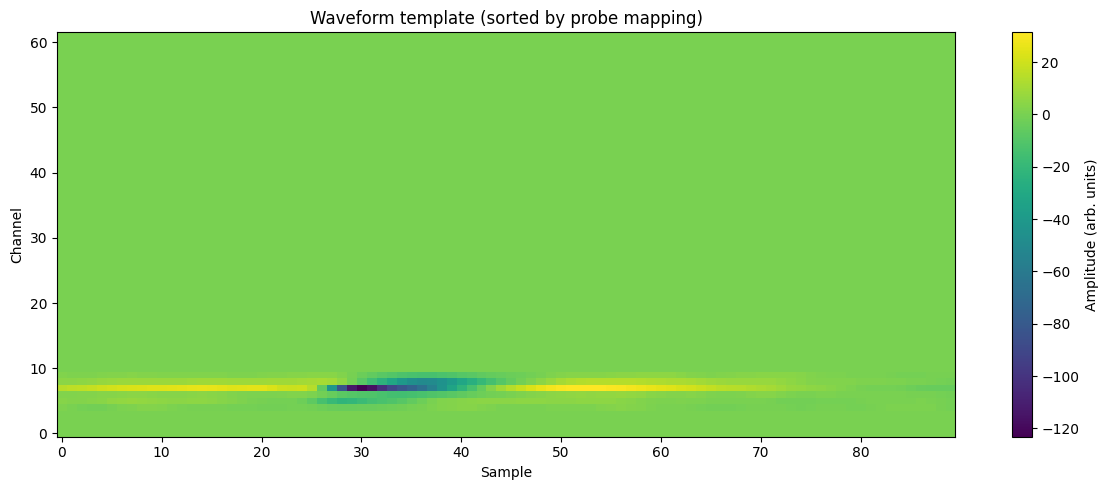

   location                                              group group_name  \
id                                                                          
19  unknown  0 pynwb.ecephys.ElectrodeGroup at 0x1318017774...          0   
3   unknown  0 pynwb.ecephys.ElectrodeGroup at 0x1318017774...          0   
12  unknown  0 pynwb.ecephys.ElectrodeGroup at 0x1318017774...          0   
5   unknown  0 pynwb.ecephys.ElectrodeGroup at 0x1318017774...          0   
14  unknown  0 pynwb.ecephys.ElectrodeGroup at 0x1318017774...          0   
..      ...                                                ...        ...   
48  unknown  1 pynwb.ecephys.ElectrodeGroup at 0x1318017774...          1   
55  unknown  1 pynwb.ecephys.ElectrodeGroup at 0x1318017774...          1   
50  unknown  1 pynwb.ecephys.ElectrodeGroup at 0x1318017774...          1   
57  unknown  1 pynwb.ecephys.ElectrodeGroup at 0x1318017774...          1   
39  unknown  1 pynwb.ecephys.ElectrodeGroup at 0x1318017774...          1   

In [7]:
# Mock NWB file ###
data_path = Path('/home/avadher/Data/Adrian/')
meta_name = 'H7100_metadata.xlsx'

# Ignore annoying warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### LOAD DATA ###
metadata = nwb.io.read_metadata_excel(data_path / meta_name, session_name, print_output=True)
start_time = nwb.io.get_start_time(session_path)

### NWB ### 
nwbfile = nwb.convert.create_nwb_file(metadata, start_time)
add_sorting_to_nwbfile(analyzer.sorting, nwbfile) # add units
add_recording_metadata_to_nwbfile(analyzer.recording, nwbfile) # add probe and everything else

### GET ANATOMICALLY SORTED WAVEFORMS FROM NWB ### 

# get electrodes table 
electrodes_table = nwbfile.electrodes.to_dataframe() # electrode_name is anatomical index (top-bottom shank-wise) 
print(electrodes_table)
electrodes_table['electrode_name'] = electrodes_table['electrode_name'].astype(int) # make sure it's int - SpikeInterface sometimes turns them to strings
electrodes_table['channel_name'] = electrodes_table['channel_name'].str.replace('CH', '', regex=False).astype(int) - 1 # now channel_name is the dat file channel index (0-based)
# To sort the waveform anatomically we need a sorting index based on the weird channel sequence used by SpikeInterface
electrodes_table = electrodes_table.sort_values(by='electrode_name') # electrode_name is contact_id, i.e. spatial sequence 
sort_ix = electrodes_table.index.to_numpy().astype(int) # use index to sort waveforms anatomically 

# load waveform 
waveforms = analyzer.get_extension("templates").get_data()
cell_number = 1  # cell 75 is obvious to track down 
wf = waveforms[cell_number,:,sort_ix] # waveforms are arranged according to a cryptic device_contact_index in SpikeInterface that gets propagated as index here

# plot waveform - it should be spatially localized 
plt.figure(figsize=(12, 5))
im = plt.imshow(wf, aspect="auto", origin="lower")
plt.ylabel("Channel")
plt.xlabel("Sample")
plt.title("Waveform template (sorted by probe mapping)")
plt.colorbar(im, label="Amplitude (arb. units)")
plt.tight_layout()
plt.show()


### EXPERIMENTATION ###

print(electrodes_table)


#print(dir(analyzer.recording))
#print(analyzer.recording.get_channel_ids())

#contact_annotations = analyzer.get_probe().contact_annotations
#analyzer.recording.set_property('channel_name', contact_annotations['acquisition_channel'])
#print(analyzer.recording.get_property('channel_name'))


#add_recording_metadata_to_nwbfile(analyzer.recording, nwbfile)


#df = nwbfile.electrodes.to_dataframe()
#print(df)
#print(df['channel_name'])

#nwbfile.units.to_dataframe().columns
#print(nwbfile.units.to_dataframe())
#print(type(nwbfile))

#print(nwbfile.devices.keys())
#df = nwbfile.electrodes.to_dataframe()
#print(df)
#woodsort.helper_functions.get_probe_mapping(analyzer.get_probe())

#print(analyzer.recording.get_probe().to_dataframe())

# replace device_indices with contact IDs

#probe_df = analyzer.get_probe().to_dataframe()
#probe_df = probe_df.drop(columns=['contact_shapes', 'width', 'height'])
#probe_df = probe_df.assign(**analyzer.get_probe().contact_annotations)
#probe_df = probe_df.sort_values(
#    by=['shank_ids', 'y'],
#    ascending=[True, False]  # or mix True / False
#)
#print(probe_df)


{'epoch': {'1': 'wake', '2': 'sleep', '3': 'wake_cue_rot'},
 'file': {'experiment_description': 'Reorientation in the head-direction system',
          'experimenter': 'Narayanan, Trisha',
          'institution': 'University of Edinburgh',
          'lab': 'Wood/Dudchenko lab',
          'name': 'H7113-250604',
          'protocol': 'day1',
          'session_description': 'Cue rotations (45, 90, 135, 180 deg)'},
 'probe': [{'description': '2x32-channels, 25 um channel spacing, implanted at 10 deg angle. '
                           'Channels sorted top to bottom of shank.',
            'id': 1,
            'location': 'left postsubiculum',
            'nshanks': 2,
            'step': 25,
            'type': 'Cambridge Neurotech H7 probe'}],
 'subject': {'dob': 250228, 'genotype': 'WT', 'line': 'Fmr1', 'sex': 'M', 'stock_id': 1906344}}

Start time from sync_messages.txt: 2025-06-04 14:46:12.720000+01:00
Creating NWB file and adding metadata...
   location  \
id            
0   unknow

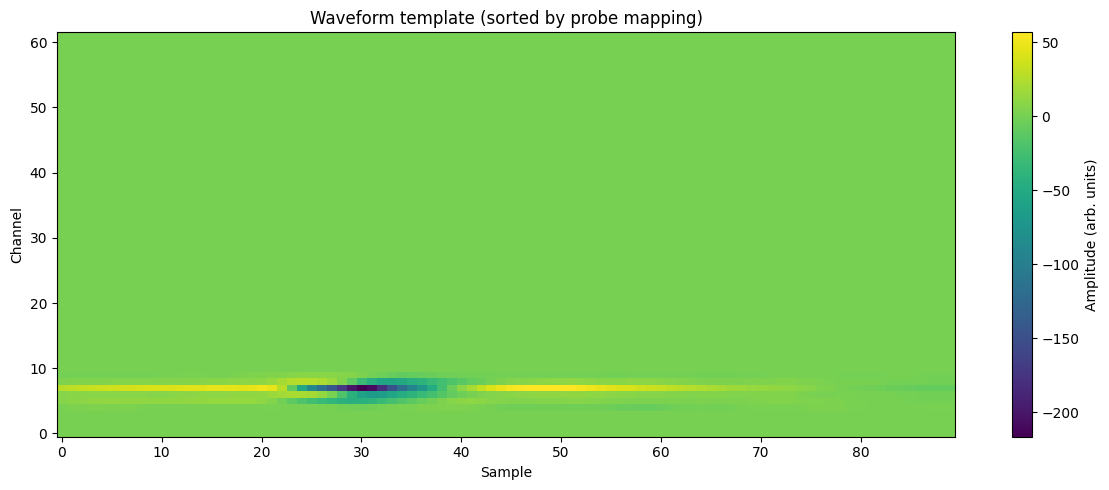

   location  \
id            
19  unknown   
3   unknown   
12  unknown   
5   unknown   
14  unknown   
26  unknown   
21  unknown   
1   unknown   
10  unknown   
17  unknown   
27  unknown   
6   unknown   
0   unknown   
8   unknown   
18  unknown   
29  unknown   
7   unknown   
28  unknown   
22  unknown   
16  unknown   
11  unknown   
2   unknown   
9   unknown   
25  unknown   
20  unknown   
15  unknown   
13  unknown   
4   unknown   
24  unknown   
23  unknown   
35  unknown   
36  unknown   
58  unknown   
47  unknown   
43  unknown   
40  unknown   
33  unknown   
51  unknown   
60  unknown   
49  unknown   
44  unknown   
38  unknown   
32  unknown   
53  unknown   
46  unknown   
42  unknown   
30  unknown   
54  unknown   
61  unknown   
56  unknown   
31  unknown   
41  unknown   
45  unknown   
52  unknown   
59  unknown   
37  unknown   
34  unknown   
48  unknown   
55  unknown   
50  unknown   
57  unknown   
39  unknown   

                                       

In [22]:
# set parameters for spike sorting
sorter = "mountainsort5"
analyzer_metrics_path = 'params/default_analyzer_metrics.json' # list of metrics for Analyzer to compute 
analyzer_metrics_path = Path(woodsort.__file__).parent / analyzer_metrics_path
spikesorting_folder_name = f"{session_name}_sorting_{sorter}"
spikesorting_path =session_path / spikesorting_folder_name
analyzer_folder_name = f"{session_name}_analyzer_{sorter}"
analyzer_path = session_path / analyzer_folder_name
curation_path = analyzer_path / 'spikeinterface_gui/curation_data.json'


# Mock NWB file ###
data_path = Path('/home/avadher/Data/Adrian/')
meta_name = 'H7100_metadata.xlsx'

analyzer_other = si.load_sorting_analyzer(analyzer_path)

# Ignore annoying warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### LOAD DATA ###
metadata = nwb.io.read_metadata_excel(data_path / meta_name, session_name, print_output=True)
start_time = nwb.io.get_start_time(session_path)

### NWB ### 
nwbfile = nwb.convert.create_nwb_file(metadata, start_time)
add_sorting_to_nwbfile(analyzer.sorting, nwbfile) # add units
add_recording_metadata_to_nwbfile(analyzer.recording, nwbfile) # add probe and everything else

### GET ANATOMICALLY SORTED WAVEFORMS FROM NWB ### 

# get electrodes table 
electrodes_table = nwbfile.electrodes.to_dataframe() # electrode_name is anatomical index (top-bottom shank-wise) 
electrodes_table['channel_name'] = electrodes_table['channel_name'].str.replace('CH', '', regex=False).astype(int) - 1 # now channel_name is the dat file channel index (0-based)

# To sort the waveform anatomically by shank and then by the y coordinate
electrodes_table = electrodes_table.sort_values(by=['aggregation_key', 'rel_y'], ascending=[True, False])
sort_ix = electrodes_table.index.to_numpy().astype(int) # use index to sort waveforms anatomically 

# load waveform 
waveforms = analyzer.get_extension("templates").get_data()
cell_number = 1  # cell 75 is obvious to track down 
wf = waveforms[cell_number,:,sort_ix] # waveforms are arranged according to a cryptic device_contact_index in SpikeInterface that gets propagated as index here

# plot waveform - it should be spatially localized 
plt.figure(figsize=(12, 5))
im = plt.imshow(wf, aspect="auto", origin="lower")
plt.ylabel("Channel")
plt.xlabel("Sample")
plt.title("Waveform template (sorted by probe mapping)")
plt.colorbar(im, label="Amplitude (arb. units)")
plt.tight_layout()
plt.show()


### EXPERIMENTATION ###

print(electrodes_table)

In [13]:
print(analyzer.folder)

/home/avadher/Data/H7113-250604/Test_all_channels


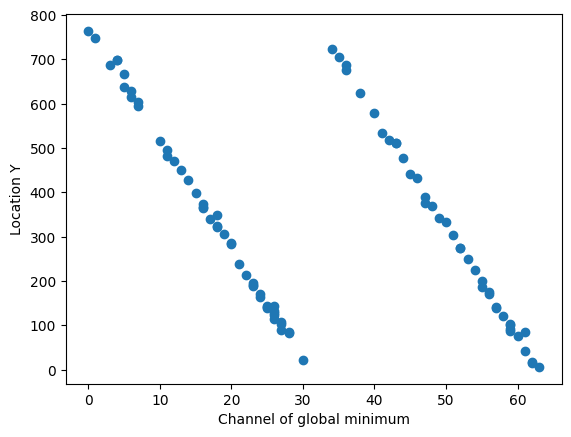

In [71]:
### Correlate waveform location with unit location ###  

unit_locations = analyzer.get_extension("unit_locations").get_data()
unit_locations_y = unit_locations[:,1]
waveforms = analyzer.get_extension("templates").get_data()
mapping = dict(zip(analyzer.get_probe().device_channel_indices, analyzer.get_probe().contact_ids))
order = sorted(mapping, key=lambda k: int(mapping[k]))
waveforms_sorted = waveforms[:,:,order]
mins_over_samples = waveforms_sorted.min(axis=1)
min_channel = mins_over_samples.argmin(axis=1)

plt.figure()
plt.scatter(min_channel, unit_locations_y)
plt.xlabel("Channel of global minimum")
plt.ylabel("Location Y")
plt.show()

recording = si.read_openephys(session_path,stream_id='0')
recording.get_property('channel_name')
print(dir(recording))


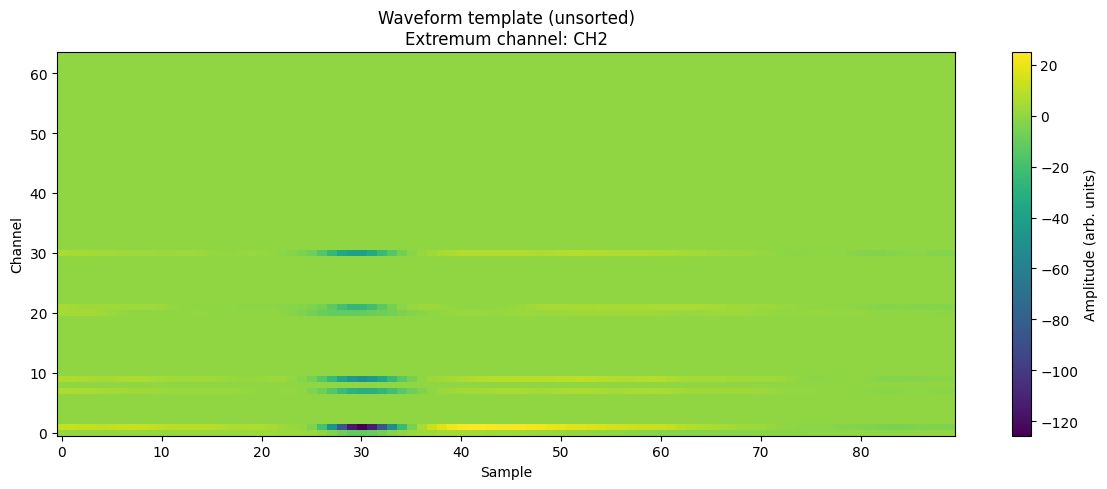

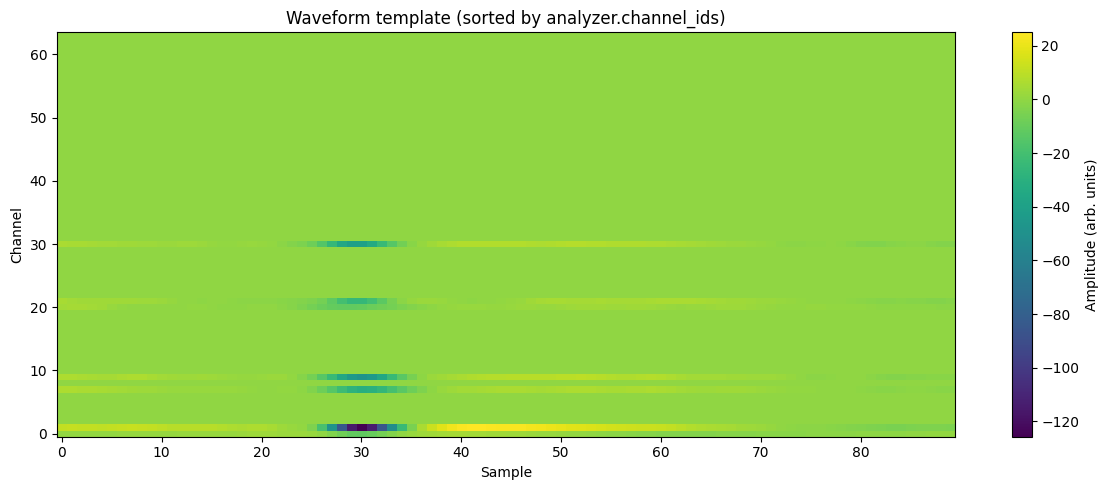

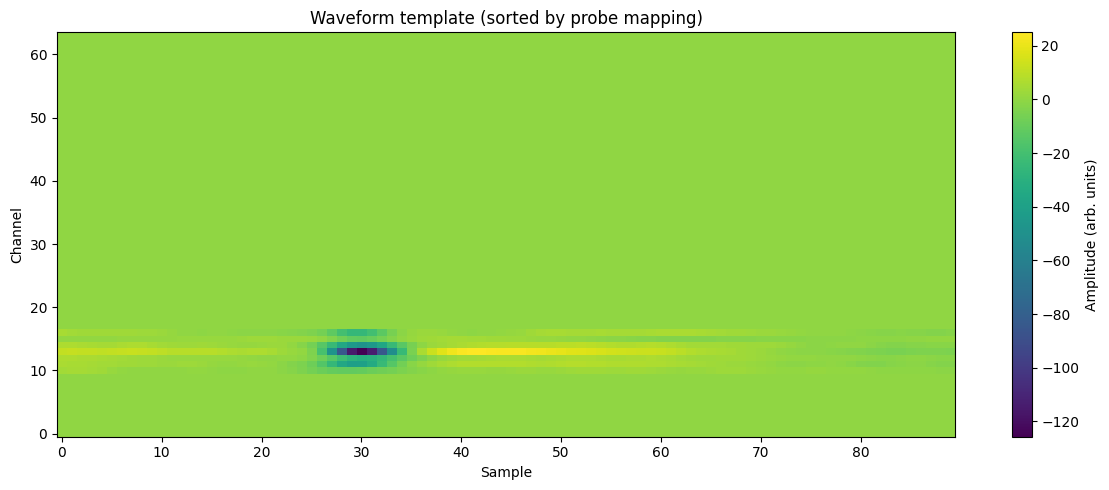

In [9]:
### PLOT WAVEFORMS ###

waveforms = analyzer.get_extension("templates").get_data()
cell_number = 1  # cell 75 is obvious to track down 
wf = waveforms[cell_number,:,:].T

# Get template extremum channel
si.get_template_extremum_channel?
extremum_channels = si.get_template_extremum_channel(analyzer, peak_sign="neg", outputs="id")
extremum_channels = np.array(list(extremum_channels.values()))
            
# Plot waveforms (unsorted)
plt.figure(figsize=(12, 5))
im = plt.imshow(wf, aspect="auto", origin="lower")
plt.ylabel("Channel")
plt.xlabel("Sample")
plt.title(f"Waveform template (unsorted)\nExtremum channel: {extremum_channels[cell_number]}")
plt.colorbar(im, label="Amplitude (arb. units)")
plt.tight_layout()
plt.show()

# Plot waveforms (sorted by analyzer.channel_ids)
order = np.array(
    [int(ch.replace("CH", "")) for ch in analyzer.channel_ids],
    dtype=int
)
order = order - 1  # make 0-based
plt.figure(figsize=(12, 5))
im = plt.imshow(wf[order], aspect="auto", origin="lower")
plt.ylabel("Channel")
plt.xlabel("Sample")
plt.title("Waveform template (sorted by analyzer.channel_ids)")
plt.colorbar(im, label="Amplitude (arb. units)")
plt.tight_layout()
plt.show()

# Plot waveforms (sorted by probe mapping)
mapping = dict(zip(analyzer.get_probe().device_channel_indices, analyzer.get_probe().contact_ids))
order = sorted(mapping, key=lambda k: int(mapping[k]))

plt.figure(figsize=(12, 5))
im = plt.imshow(wf[order], aspect="auto", origin="lower")
plt.ylabel("Channel")
plt.xlabel("Sample")
plt.title("Waveform template (sorted by probe mapping)")
plt.colorbar(im, label="Amplitude (arb. units)")
plt.tight_layout()
plt.show()

# Plot waveforms (sorted by acquisition channel) 